This notebook was taken from https://github.com/JWarmenhoven/ISLR-python/blob/master/Notebooks/Chapter%206.ipynb

### Linear Model Selection and Regularization

In [82]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cross_decomposition import PLSRegression

%matplotlib inline
plt.style.use('seaborn-white')

In [10]:
df = pd.read_csv('../../data/Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


In [11]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [12]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0           1            1   

                   NewLeague_N  
Player                          
-Alan Ashby             

In [13]:
y = df.Salary
# Drop the column with the dependent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7+ KB


In [14]:
X.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
-Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


In [16]:
X_train = pd.read_csv('../../data/Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('../../data/Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('../../data/Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('../../data/Hitters_y_test.csv', index_col=0)

## 1. Ridge

The glmnet algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

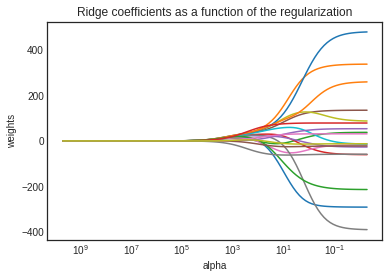

In [21]:
alphas = 10**np.linspace(10,-2,100)*0.5
ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X),y)
    coefs.append(ridge.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

The above plot shows that the Ridge coefficients get larger when we decrease alpha. Get **Alpha = 4**

In [23]:
scaler = StandardScaler().fit(X_train)

In [26]:
ridge2 = Ridge(alpha=len(X_)*11498/2)
ridge2.fit(scaler.transform(X_train), y_train)
pred = ridge2.predict(scaler.transform(X_test))
mean_squared_error(y_test, pred)

193147.46143016344

In [27]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat          0.015146
Hits           0.016050
HmRun          0.013561
Runs           0.015681
RBI            0.016782
Walks          0.019662
Years          0.010390
CAtBat         0.016570
CHits          0.017627
CHmRun         0.015072
CRuns          0.018771
CRBI           0.016697
CWalks         0.016821
PutOuts        0.003228
Assists       -0.007600
Errors         0.013672
League_N       0.003519
Division_W     0.003339
NewLeague_N    0.003499
dtype: float64

Alpha = $10^{10}$

This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [29]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

193253.09741651407

### Compute the regularization path using RidgeCV

In [32]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

RidgeCV(alphas=array([5.00000e+09, 3.78232e+09, ..., 6.60971e-03, 5.00000e-03]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [33]:
ridgecv.alpha_

115.5064850041579

In [34]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))

97384.9295917259

In [35]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat           7.576771
Hits           22.596030
HmRun          18.971990
Runs           20.193945
RBI            21.063875
Walks          55.713281
Years          -4.687149
CAtBat         20.496892
CHits          29.230247
CHmRun         14.293124
CRuns          35.881788
CRBI           20.212172
CWalks         24.419768
PutOuts        16.128910
Assists       -44.102264
Errors         54.624503
League_N        5.771464
Division_W     -0.293713
NewLeague_N    11.137518
dtype: float64

### 2. The Lasso

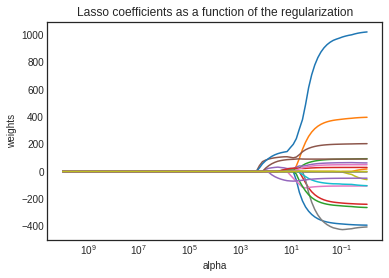

In [38]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [41]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.values.ravel())

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [42]:
lassocv.alpha_

30.01382256446427

In [43]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

102924.90954696966

In [44]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits             0.000000
HmRun            2.154219
Runs             0.000000
RBI             30.835560
Walks          104.071528
Years           -0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           0.000000
CRuns          132.858095
CRBI             0.000000
CWalks           0.000000
PutOuts          1.896185
Assists        -51.058752
Errors          76.779641
League_N         0.000000
Division_W       0.000000
NewLeague_N      0.000000
dtype: float64

### 3. Principal components regression

Scikit-klearn does not have an implementation of PCA and regression combined like the 'pls' package in R. https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf

In [68]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

(19, 19)


,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


In [69]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

(263, 19)


,0,1,2,3,4,5
0,-0.009649,1.870522,1.265145,-0.935481,1.109636,1.211972
1,0.411434,-2.429422,-0.909193,-0.264212,1.232031,1.826617
2,3.466822,0.825947,0.555469,-1.616726,-0.857488,-1.028712
3,-2.558317,-0.230984,0.519642,-2.176251,-0.820301,1.491696
4,1.027702,-1.573537,1.331382,3.494004,0.983427,0.513675


In [70]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3116: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


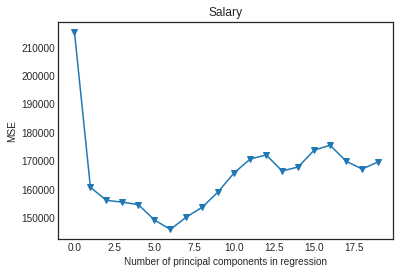

In [78]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 6 components.

**Transform test data with PCA loadings and fit regression on 6 principal components**

In [79]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

96320.02078250323

### 4. Partial Least Squares


Scikit-learn PLSRegression gives same results as the pls package in R when using 'method='oscorespls'. In the LAB excercise, the standard method is used which is 'kernelpls'.

When doing a slightly different fitting in R, the result is close to the one obtained using scikit-learn.

pls.fit=plsr(Salary~., data=Hitters, subset=train, scale=TRUE, validation="CV", method='oscorespls')
validationplot(pls.fit,val.type="MSEP", intercept = FALSE)

See documentation: http://scikit-learn.org/dev/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression


/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3116: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


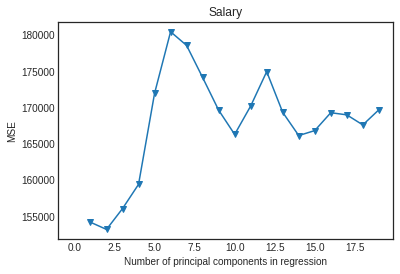

In [83]:
# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [84]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

102234.27995999217